In [1]:
# Liang's work before leaving:
# schedule a meeting to intorduce the S2S work I have completed
# convert the Jupyter Note book to python script and run the script on HPC (need Janghyun's help)
# answer questions and assist the merging of code to Wattile (need Hannah's help)

# Key concerns to merge it to current Wattile:
# cannot find a way to better integrate multiple loss function

# Liang's future work after leaving:
# continue to contribute to journal paper and case studies
# Test more on the Building Data Genome Project
# train the model using variable-time-horizon training data and applied in variable-time-horizon inference applications

In [2]:
import numpy as np
import pandas as pd
import random
import time
import math
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sg_filter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

### Choose site: `cafe` or `synthetic`

In [3]:
# site = "cafe"
site = "synthetic"

### Prepare input/output data for modeling from raw data
The variables `process_raw_cafe_data` and `process_raw_synthetic_data` control whether to redo the pre-processing

Generate a DataFrame with all sensors and time indicators. The last column of the DataFrame is the output energy.

It saves the processed DataFrame as csv files.

Data here is still two-dimensional.

In [4]:
# process cafe data
if site == "cafe":
    process_raw_cafe_data = False

    if process_raw_cafe_data:
        final_df = pd.DataFrame([])

        # select number of month here:
        date_list = [x[-11:-4] for x in os.listdir("data/Cafe/") if x[-3:] == "csv"] #[0:12]

        for date in date_list:
            print(f"Processing: {date}")
            temp_df = pd.read_csv(f'data/Cafe/Cafe Predictors {date}.csv').drop(columns = ['SRRL BMS Opaque Cloud Cover','SRRL BMS Total Cloud Cover']).dropna()
            temp_output = pd.read_csv(f'data/Cafe/Cafe Targets {date}.csv')
            temp_df['Timestamp'] = temp_df['Timestamp'].map(lambda x: parser.parse(x[0:-13]))

            processed_df =  temp_df.iloc[:,1:].astype(float)

            #     processed_df['year'] = temp_df['Timestamp'].map(lambda x: float(x.year))
            #     processed_df['month_of_yr'] =  temp_df['Timestamp'].map(lambda x: float(x.month))
            #     processed_df['day_of_yr'] =  temp_df['Timestamp'].map(lambda x: float(x.timetuple().tm_yday))
            #     processed_df['day_of_month'] =  temp_df['Timestamp'].map(lambda x: float(x.day))
            processed_df['day_of_week'] =  temp_df['Timestamp'].map(lambda x: float(x.weekday()))
            processed_df['weekend'] =  processed_df['day_of_week'].map(lambda x: float(x>4))
            processed_df['hour'] =  temp_df['Timestamp'].map(lambda x: float(x.hour))
            processed_df['minute'] =  temp_df['Timestamp'].map(lambda x: float(x.minute))

            processed_df['usage'] =  temp_output['Cafe Whole Building Real Power Total'].astype(float)

            final_df = pd.concat([final_df, processed_df], axis = 0)

        final_df = final_df.dropna()
        final_df = final_df.reset_index(drop = True)

        final_df.to_csv('data/Cafe_dataset_2.csv', index = None)

elif site == "synthetic":
    # process synthetic data
    process_raw_synthetic_data = False

    if process_raw_synthetic_data:

        final_df = pd.DataFrame([])

        date_list = ['2021-12-01','2021-12-02','2021-12-03','2021-12-04','2021-12-05','2021-12-06','2021-12-07']

        for date in date_list:
            temp_df = pd.read_csv(f'data/Synthetic Site/Synthetic Site Predictors {date}.csv')
            temp_output = pd.read_csv(f'data/Synthetic Site/Synthetic Site Targets {date}.csv')

            temp_df['Timestamp'] = temp_df['Timestamp'].map(lambda x: parser.parse(x[0:-13]))

            processed_df =  temp_df.iloc[:,1:].astype(float)

        #     processed_df['year'] = temp_df['Timestamp'].map(lambda x: float(x.year))
        #     processed_df['month_of_yr'] =  temp_df['Timestamp'].map(lambda x: float(x.month))
        #     processed_df['day_of_yr'] =  temp_df['Timestamp'].map(lambda x: float(x.timetuple().tm_yday))
        #     processed_df['day_of_month'] =  temp_df['Timestamp'].map(lambda x: float(x.day))
            processed_df['day_of_week'] =  temp_df['Timestamp'].map(lambda x: float(x.weekday()))
            processed_df['weekend'] =  processed_df['day_of_week'].map(lambda x: float(x>4))
            processed_df['hour'] =  temp_df['Timestamp'].map(lambda x: float(x.hour))
            processed_df['minute'] =  temp_df['Timestamp'].map(lambda x: float(x.minute))

            processed_df['usage'] =  temp_output['Synthetic Site Electricity Main Total Power'].astype(float)

            final_df = pd.concat([final_df, processed_df], axis = 0)

        final_df = final_df.dropna()
        final_df = final_df.reset_index(drop = True)

        final_df.to_csv('data/Synthetic Site_dataset_2.csv', index = None)

else:
    raise Exception("The variable of 'site' should either be 'cafe' or 'synthetic'.")

### Three types of S2S model structures with different attention model
class `S2S_Model`: vanilla S2S model without attention model

class `S2S_BA_Model`: S2S model with Bahdanau Attention model (https://machinelearningmastery.com/the-bahdanau-attention-mechanism/)

class `S2S_LA_Model`: S2S model with Luong Attention module (https://machinelearningmastery.com/the-luong-attention-mechanism/). `attn` module is part of `S2S_LA_Model`

Each model structure can select RNN cell type, including `lstm`, `RNN`, `gru`

Three model structures are parallel. Each run defines one model structure. The selection of model structure is only used for sensitivity analysis and comparison study. In the future when we decide one model structure, we can delete the rest options.

In [5]:
#########################################################################################
# building the S2S model
class S2S_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(self.hidden_size, 1)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters. Refer to Saxe at al. paper that explains why to use orthogonal init weights
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # encoder forward function
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            h = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h

    def predict(self, pred_usage, h, target_length):
        # decoder forward function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h[0])
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#########################################################################################
# Bahdanau Attention model
# refer to : AuCson github code
# building the model
class S2S_BA_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_BA_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.use_cuda = use_cuda
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1+self.hidden_size, self.hidden_size)

        self.Wattn_energies = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.Wusage = nn.Linear(self.hidden_size, 1)
        self.Wout = nn.Linear(1+self.hidden_size*2, self.hidden_size)
        self.v = nn.Parameter(torch.rand(self.hidden_size))
        stdv = 1./math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)
        self.init()

# function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.Wusage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.Wusage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h_copies = h.expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h, context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h_copies = h[0].expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h[0], context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#############################################################################################3
# Luong Attention module
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, " is not an appropriate attention method, please select one of dot, general, or concat.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        if self.method == 'concat':
            self.attn = nn.Linear(2*self.hidden_size, self.hidden_size)
            self.v = nn.Parameter(torch.rand(self.hidden_size))
            stdv = 1./math.sqrt(self.v.size(0))
            self.v.data.normal_(mean=0, std=stdv)

    def dot_score(self, hidden, encoder_output):
        attn_energies = torch.sum(hidden*encoder_output, dim=2)
        return attn_energies

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        attn_energies = torch.sum(hidden*energy, dim=2)
        return attn_energies

    def concat_score(self, hidden, encoder_output):
        energy = torch.tanh(self.attn(torch.cat((hidden.expand(encoder_output.shape[0], -1, -1),
                            encoder_output), 2)))
        return torch.sum(self.v * energy, dim=2)

    # calculate the attention weights (energies) based on the given method
    def forward(self, hidden, encoder_outputs):
        if self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)
        elif self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        attn_weights = torch.softmax(attn_energies, dim=1).unsqueeze(1)
        return attn_weights

#########################################################################################
#  building the S2S LA model
class S2S_LA_Model(nn.Module):
    def __init__(self, cell_type, attn_method, input_size, hidden_size, use_cuda):
        super(S2S_LA_Model, self).__init__()
        self.cell_type = cell_type
        self.attn_method = attn_method
        self.input_size = input_size
        self.hidden_size = hidden_size

        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(hidden_size, 1)
        self.lin_concat = nn.Linear(hidden_size*2, hidden_size)
        self.attn = Attn(self.attn_method, self.hidden_size)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.lin_usage(h)
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h, encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h, context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h[0], encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h[0], context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

### main function

The `main` function process the data into three-dimensional for S2S model, train the model, and test the restuls

- def `generate_windows`: an important procedure to convert 2-dimensional data into 3-dimensional for modeling

- def `quantile_loss`: loss function with quntile number as parameter. For now, it cannot support list of quantiles as parameters.

In [6]:
#################################################################################################################################################
# main function
def main(seed, cuda, cell_type, attention_model, la_method, window_source_size,
            window_target_size, epochs, batch_size, hs, save_model, loss_function_qs, normalization):
    t0 = time.time()
    np.random.seed(seed)
    torch.manual_seed(seed)

    # loss function, qs here is an integer, not a list of integer
    def quantile_loss(output, target, qs, window_target_size):
        """
        Computes loss for quantile methods.
        :param output: (Tensor)
        :param target: (Tensor)
        :param qs: (int)
        :param window_target_size: (int)
        :return: (Tensor) Loss for this study (single number)
        """

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        resid = target - output
        tau = torch.tensor([qs], device=device).repeat_interleave(window_target_size)

        alpha = 0.001
        log_term = torch.zeros_like(resid, device=device)
        log_term[resid < 0] = torch.log(1 + torch.exp(resid[resid < 0] / alpha)) - (
            resid[resid < 0] / alpha
        )
        log_term[resid >= 0] = torch.log(1 + torch.exp(-resid[resid >= 0] / alpha))
        loss = resid * tau + alpha * log_term
        loss = torch.mean(torch.mean(loss, 0))

        return loss
    
    # Load dataset
    if site == 'cafe':
        dataset = pd.read_csv("data/Cafe_dataset_2.csv").astype(np.float32)
    elif site == 'synthetic':
        dataset = pd.read_csv("data/Synthetic Site_dataset_2.csv").astype(np.float32)        
    else: 
        raise Exception("The variable of 'site' should either be 'cafe' or 'synthetic'.")
        
    usage_actual = dataset['usage']
    mu_usage = dataset['usage'].mean()
    std_usage = dataset['usage'].std()
    dataset = dataset.values

    # Normalization
    if normalization: 
        print(f"Transforming data to 0 mean and unit var")
        MU = dataset.mean(0) # 0 means take the mean of the column
        dataset = dataset - MU
        STD = dataset.std(0) # same with std here
        dataset = dataset / STD
    else:
        MU = dataset.mean(0) # 0 means take the mean of the column
        MU = 0
        dataset = dataset - MU
        STD = dataset.std(0) # same with std here
        STD = 1
        dataset = dataset / STD

    print("Generating training and test data...")
    WINDOW_SOURCE_SIZE = window_source_size
    WINDOW_TARGET_SIZE = window_target_size

    # getting actual usage vector, aligning with predicted values vector. Aka remove first window_source_size and remaining
    usage_actual = usage_actual.values
    usage_actual = usage_actual[int(dataset.shape[0]*0.80):]
    usage_actual = usage_actual[WINDOW_SOURCE_SIZE:]

    # training testing split: 80% train, 20% test
    train_source = dataset[:int(dataset.shape[0]*0.80)]
    test_source = dataset[int(dataset.shape[0]*0.80):]

    # A key function to convert from 2D data to 3D data. 
    def generate_windows(data):
        x_train = []
        y_usage_train = []
        x_test = []
        y_usage_test = []

        # for training data
        idxs = np.random.choice(train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), replace=False)

        for idx in idxs:
            x_train.append(train_source[idx:idx+WINDOW_SOURCE_SIZE].reshape((1, WINDOW_SOURCE_SIZE, train_source.shape[1])) )
            y_usage_train.append(train_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

        x_train = np.concatenate(x_train, axis=0) # make them arrays and not lists
        y_usage_train = np.concatenate(y_usage_train, axis=0)

        # for testing data
        idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), WINDOW_TARGET_SIZE)

        for idx in idxs:
            x_test.append(test_source[idx:idx+WINDOW_SOURCE_SIZE].reshape((1, WINDOW_SOURCE_SIZE, test_source.shape[1])) )
            y_usage_test.append(test_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

        x_test = np.concatenate(x_test, axis=0) # make them arrays and not lists
        y_usage_test = np.concatenate(y_usage_test, axis=0)

        return x_train, y_usage_train, x_test, y_usage_test

    X_train, Y_train_usage, X_test, Y_test_usage = generate_windows(dataset)
    print("Created {} train samples and {} test samples".format(X_train.shape[0], X_test.shape[0]))
    idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), WINDOW_TARGET_SIZE)
    remainder = len(test_source) - (idxs[-1] + WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE)
    usage_actual = usage_actual[:-remainder]

#################################################################################################################################################
# call the model
    #print("Creating model...")
    INPUT_SIZE = X_train.shape[-1]
    HIDDEN_SIZE = hs
    CELL_TYPE = cell_type
    LA_METHOD = la_method

    # call the respective model
    if attention_model == 'none':
        model = S2S_Model(CELL_TYPE, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    elif attention_model == 'BA':
        model = S2S_BA_Model(CELL_TYPE, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    elif attention_model == 'LA':
        model = S2S_LA_Model(CELL_TYPE, LA_METHOD, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    if cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        model.cuda()

    print("MODEL ARCHITECTURE IS: ")
    print(model)

    print("\nModel parameters are on cuda: {}".format(next(model.parameters()).is_cuda))

    opt = optim.Adam(model.parameters(), lr=1e-3)
#     loss_fn = nn.MSELoss(reduction='sum')
    loss_fn = quantile_loss
    
    EPOCHES = epochs
    BATCH_SIZE = batch_size

    print("\nStarting training...")

    train_loss = []
    test_loss = []

    for epoch in range(EPOCHES):
        t_one_epoch = time.time()
        print("Epoch {}".format(epoch+1))
        total_usage_loss = 0
        for b_idx in range(0, X_train.shape[0], BATCH_SIZE):

            x = torch.from_numpy(X_train[b_idx:b_idx+BATCH_SIZE]).float()
            y_usage = torch.from_numpy(Y_train_usage[b_idx:b_idx+BATCH_SIZE]).float()

            if cuda:
                x = x.cuda()
                y_usage = y_usage.cuda()

            # encoder forward, for respective models (with and without attention)
            if attention_model == 'none':
                pred_usage, h = model.consume(x)

            elif attention_model == 'BA':
                pred_usage, h, encoder_outputs = model.consume(x)

            elif attention_model == 'LA':
                pred_usage, h, encoder_outputs = model.consume(x)

            # decoder forward, for respective models
            if attention_model == 'none':
                preds = model.predict(pred_usage, h, WINDOW_TARGET_SIZE)

            elif attention_model == 'BA':
                preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

            elif attention_model == 'LA':
                preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

            # compute lose
            loss_usage = loss_fn(preds, y_usage, qs = loss_function_qs, window_target_size=window_target_size)

            # backprop and update
            opt.zero_grad()

            loss_usage.sum().backward()

            opt.step()

#             total_usage_loss += loss_usage.item()
            
        train_loss.append(total_usage_loss)
        print("\tTRAINING: {} total train USAGE loss.\n".format(total_usage_loss))

#################################################################################################################################################
# TESTING
        y_usage = None
        pred_usage = None
        preds = None
        total_usage_loss = 0
        all_preds = []

        for b_idx in range(0, X_test.shape[0], BATCH_SIZE):
            with torch.no_grad():
                x = torch.from_numpy(X_test[b_idx:b_idx+BATCH_SIZE])
                y_usage = torch.from_numpy(Y_test_usage[b_idx:b_idx+BATCH_SIZE])

                if cuda:
                    x = x.cuda()
                    y_usage = y_usage.cuda()

                # encoder forward, for respective models
                if attention_model == 'none':
                    pred_usage, h = model.consume(x)

                elif attention_model == 'BA':
                    pred_usage, h, encoder_outputs = model.consume(x)

                elif attention_model == 'LA':
                    pred_usage, h, encoder_outputs = model.consume(x)

                # decoder forward, for respective models
                if attention_model == 'none':
                    preds = model.predict(pred_usage, h, WINDOW_TARGET_SIZE)

                elif attention_model == 'BA':
                    preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

                elif attention_model == 'LA':
                    preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

                # compute loss
                loss_usage = loss_fn(preds, y_usage, qs = loss_function_qs, window_target_size=window_target_size)

                if (epoch == epochs-1):
                    all_preds.append(preds)

        test_loss.append(total_usage_loss)

        print("\tTESTING: {} total test USAGE loss".format(total_usage_loss))
        print("\tTESTING:\n")
        print("\tSample of prediction:")
        print("\t\t TARGET: {}".format(y_usage[-1].cpu().detach().numpy().flatten()))
        print("\t\t   PRED: {}\n\n".format(preds[-1].cpu().detach().numpy().flatten()))

        y_last_usage = y_usage[-1].cpu().detach().numpy().flatten()
        pred_last_usage = preds[-1].cpu().detach().numpy().flatten()
        t2_one_epoch = time.time()
        time_one_epoch = t2_one_epoch - t_one_epoch
        print("TIME OF ONE EPOCH: {} seconds and {} minutes".format(time_one_epoch, time_one_epoch/60.0))

####################################################################################################
# SAVING MODEL
    if save_model:
        torch.save(model.state_dict(), "MODEL_w:__seed={}_cell_type={}_attention_model={}_la_method={}_T={}_N={}_bs={}_hs={}".format(
            seed, cell_type, attention_model, la_method,
            window_source_size, window_target_size, batch_size, hs))

#################################################################################################################################################
# RESULTS
    # for plotting and accuracy
    preds = torch.cat(all_preds, 0)
    preds = preds.cpu().detach().numpy().flatten()
    actual = Y_test_usage.flatten()

    # for loss plotting
    train_loss_array = np.asarray(train_loss)
    test_loss_array = np.asarray(test_loss)
    len_loss = np.arange(len(train_loss_array))

    # unnormalizing 1
    if normalization:
        preds_unnorm = (preds*std_usage) + mu_usage
    else:
        preds_unnorm = preds

    # using the actual usage from top of script here
    mae3 = (sum(abs(usage_actual - preds_unnorm)))/(len(usage_actual))
    mape3 = (sum(abs((usage_actual - preds_unnorm)/usage_actual)))/(len(usage_actual))

    # for std
    mape_s = (abs((usage_actual - preds_unnorm)/usage_actual))
    s = mape_s.std()
    mae_s = abs(usage_actual - preds_unnorm)
    s2 = mae_s.std()
    print("\n\tACTUAL ACC. RESULTS: MAE, MAPE: {} and {}%".format(mae3, mape3*100.0))
    
    if not os.path.exists(f'results/{site}'):
        os.makedirs(f'results/{site}')
    
    pd.DataFrame(preds, columns = [f'q{loss_function_qs}']).to_csv(f'results/{site}/q{loss_function_qs}.csv', index = None)
    pd.DataFrame(actual, columns = [f'actual']).to_csv(f'results/{site}/actual.csv', index = None)

    # total time of run
    t1 = time.time()
    total = t1-t0
    print("\nTIME ELAPSED: {} seconds OR {} minutes".format(total, total/60.0))
    print("\nEnd of run")
    plt.show()
    for_plotting = [usage_actual, preds_unnorm, y_last_usage, pred_last_usage]
    return s, s2, mape_s, mae_s, mae3, mape3, total/60.0, train_loss, test_loss, for_plotting, MU, STD

In [7]:
# cafe data is too large to set a high epochs number to run on my local machine
if site == 'cafe':
    n_epochs = 1
elif site == 'synthetic':
    n_epochs = 10
else:
    raise Exception("The variable of 'site' should either be 'cafe' or 'synthetic'.")

for loss_function_qs in [0.05, 0.25, 0.50, 0.75, 0.95]: #[0.50]:#[0.05, 0.50, 0.95]:
    print(f"Processing loss function alpha: {loss_function_qs}")
    if __name__ == "__main__":
        s, s2, mape_s, mae_s, mae, mape, total_mins, train_loss, test_loss, for_plotting, MU, STD = main(seed=42, cuda=True,
            cell_type='lstm', attention_model='BA', la_method='none',
            window_source_size=12, window_target_size=3, epochs=n_epochs,
            batch_size=256, hs=64, save_model=False, loss_function_qs = loss_function_qs, normalization = False)

Processing loss function alpha: 0.05
Generating training and test data...
Created 8045 train samples and 667 test samples
MODEL ARCHITECTURE IS: 
S2S_BA_Model(
  (Ecell): LSTMCell(12, 64)
  (Dcell): LSTMCell(65, 64)
  (Wattn_energies): Linear(in_features=128, out_features=64, bias=True)
  (Wusage): Linear(in_features=64, out_features=1, bias=True)
  (Wout): Linear(in_features=129, out_features=64, bias=True)
)

Model parameters are on cuda: True

Starting training...
Epoch 1
	TRAINING: 0 total train USAGE loss.

	TESTING: 0 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [104.9148     8.0028     8.330399]
		   PRED: [28.679508 38.768967 42.058544]


TIME OF ONE EPOCH: 0.9551346302032471 seconds and 0.01591891050338745 minutes
Epoch 2
	TRAINING: 0 total train USAGE loss.

	TESTING: 0 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [104.9148     8.0028     8.330399]
		   PRED: [59.164673 87.40982  99.720985]


TIME OF ONE EPOCH: 0.7449123859405518 se

	TRAINING: 0 total train USAGE loss.

	TESTING: 0 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [104.9148     8.0028     8.330399]
		   PRED: [105.58467 104.28246 103.17189]


TIME OF ONE EPOCH: 0.8630039691925049 seconds and 0.014383399486541748 minutes
Epoch 5
	TRAINING: 0 total train USAGE loss.

	TESTING: 0 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [104.9148     8.0028     8.330399]
		   PRED: [104.6829   104.92134  104.177734]


TIME OF ONE EPOCH: 0.8543148040771484 seconds and 0.014238580067952474 minutes
Epoch 6
	TRAINING: 0 total train USAGE loss.

	TESTING: 0 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [104.9148     8.0028     8.330399]
		   PRED: [105.80233 106.13535 105.54703]


TIME OF ONE EPOCH: 0.8848311901092529 seconds and 0.014747186501820882 minutes
Epoch 7
	TRAINING: 0 total train USAGE loss.

	TESTING: 0 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [104.9148     8.0028     8.3

	TRAINING: 0 total train USAGE loss.

	TESTING: 0 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [104.9148     8.0028     8.330399]
		   PRED: [110.862045 111.0988   111.7281  ]


TIME OF ONE EPOCH: 0.8782823085784912 seconds and 0.014638038476308186 minutes
Epoch 10
	TRAINING: 0 total train USAGE loss.

	TESTING: 0 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [104.9148     8.0028     8.330399]
		   PRED: [111.27394 110.83656 110.7907 ]


TIME OF ONE EPOCH: 0.9159176349639893 seconds and 0.015265293916066488 minutes

	ACTUAL ACC. RESULTS: MAE, MAPE: 9.1238826997634 and 13.233248815388936%

TIME ELAPSED: 8.842347145080566 seconds OR 0.14737245241800945 minutes

End of run


### Cafe Visualization

In [3]:
site = "cafe"

q95 = pd.read_csv(f'results/{site}/q0.95.csv')
q75 = pd.read_csv(f'results/{site}/q0.75.csv')
q50 = pd.read_csv(f'results/{site}/q0.5.csv')
q25 = pd.read_csv(f'results/{site}/q0.25.csv')
q05 = pd.read_csv(f'results/{site}/q0.05.csv')
actual = pd.read_csv(f'results/{site}/actual.csv')

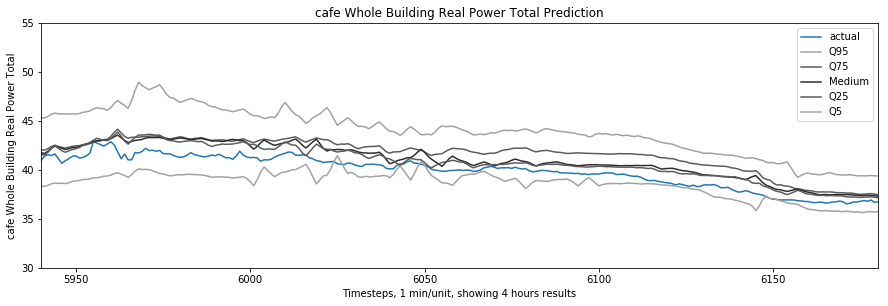

In [4]:
plt.figure(figsize=(15, 4.5))

plt.title(f'{site} Whole Building Real Power Total Prediction')

plt.plot(actual, label = 'actual')
plt.plot(sg_filter(q95.values.flatten(),5,2), label = 'Q95', color = '#a2a2a2')
plt.plot(sg_filter(q75.values.flatten(),5,2), label = 'Q75', color = '#5b5b5b')
plt.plot(sg_filter(q50.values.flatten(),5,2), label = 'Medium', color = '#322b2b')
plt.plot(sg_filter(q25.values.flatten(),5,2), label = 'Q25', color = '#5b5b5b')
plt.plot(sg_filter(q05.values.flatten(),5,2), label = 'Q5', color = '#a2a2a2')

plt.legend()
plt.ylim(30,55)
n = 5700
plt.xlim(240 + n, 480 + n)

plt.ylabel(f'{site} Whole Building Real Power Total')
plt.xlabel('Timesteps, 1 min/unit, showing 4 hours results')

plt.show()

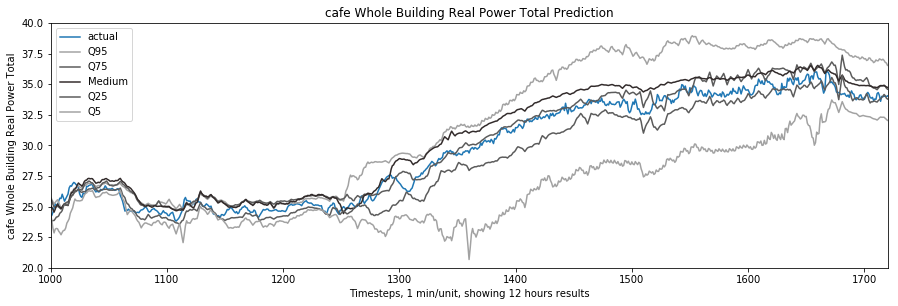

In [5]:
plt.figure(figsize=(15, 4.5))

plt.title(f'{site} Whole Building Real Power Total Prediction')

plt.plot(actual, label = 'actual')
plt.plot(sg_filter(q95.values.flatten(),5,2), label = 'Q95', color = '#a2a2a2')
plt.plot(sg_filter(q75.values.flatten(),5,2), label = 'Q75', color = '#5b5b5b')
plt.plot(sg_filter(q50.values.flatten(),5,2), label = 'Medium', color = '#322b2b')
plt.plot(sg_filter(q25.values.flatten(),5,2), label = 'Q25', color = '#5b5b5b')
plt.plot(sg_filter(q05.values.flatten(),5,2), label = 'Q5', color = '#a2a2a2')


plt.legend()

plt.ylim(20,40)
n=0
plt.xlim(1000, 1720)

plt.ylabel(f'{site} Whole Building Real Power Total')
plt.xlabel('Timesteps, 1 min/unit, showing 12 hours results')

plt.show()

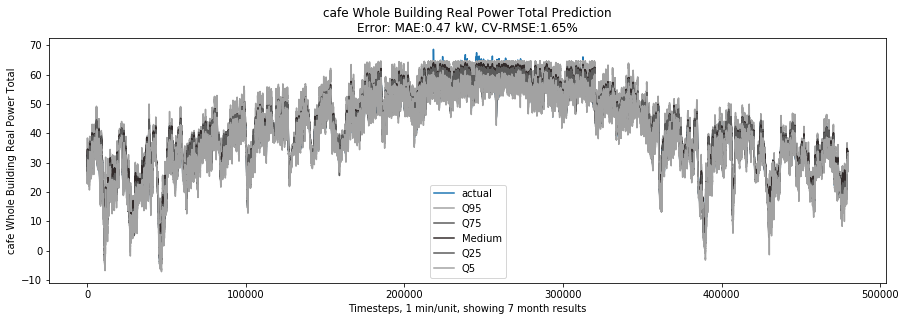

In [6]:
plt.figure(figsize=(15, 4.5))

# calculating error
y_actual = actual
y_predicted = q50.values.flatten()
MSE = mean_squared_error(y_actual, y_predicted)
RMSE = MSE**0.5
CV_RMSE = RMSE/y_actual.mean().values[0]
mae = mean_absolute_error(y_actual, y_predicted)

plt.title(f'{site} Whole Building Real Power Total Prediction\nError: MAE:{mae:.2f} kW, CV-RMSE:{CV_RMSE*100:.2f}%')

plt.plot(actual, label = 'actual')
plt.plot(sg_filter(q95.values.flatten(),5,2), label = 'Q95', color = '#a2a2a2')
plt.plot(sg_filter(q75.values.flatten(),5,2), label = 'Q75', color = '#5b5b5b')
plt.plot(sg_filter(q50.values.flatten(),5,2), label = 'Medium', color = '#322b2b')
plt.plot(sg_filter(q25.values.flatten(),5,2), label = 'Q25', color = '#5b5b5b')
plt.plot(sg_filter(q05.values.flatten(),5,2), label = 'Q5', color = '#a2a2a2')


plt.legend()

# plt.ylim(20,40)
# n=0
# plt.xlim(1000, 1720)

plt.ylabel(f'{site} Whole Building Real Power Total')
plt.xlabel('Timesteps, 1 min/unit, showing 7 month results')

plt.show()

### synthetic data visualization

In [7]:
site = "synthetic"

q95 = pd.read_csv(f'results/{site}/q0.95.csv')
q75 = pd.read_csv(f'results/{site}/q0.75.csv')
q50 = pd.read_csv(f'results/{site}/q0.5.csv')
q25 = pd.read_csv(f'results/{site}/q0.25.csv')
q05 = pd.read_csv(f'results/{site}/q0.05.csv')
actual = pd.read_csv(f'results/{site}/actual.csv')

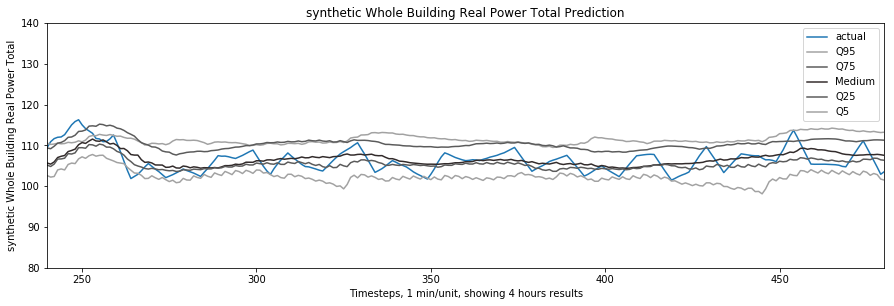

In [8]:
plt.figure(figsize=(15, 4.5))

plt.title(f'{site} Whole Building Real Power Total Prediction')

plt.plot(actual, label = 'actual')
plt.plot(sg_filter(q95.values.flatten(),5,2), label = 'Q95', color = '#a2a2a2')
plt.plot(sg_filter(q75.values.flatten(),5,2), label = 'Q75', color = '#5b5b5b')
plt.plot(sg_filter(q50.values.flatten(),5,2), label = 'Medium', color = '#322b2b')
plt.plot(sg_filter(q25.values.flatten(),5,2), label = 'Q25', color = '#5b5b5b')
plt.plot(sg_filter(q05.values.flatten(),5,2), label = 'Q5', color = '#a2a2a2')

plt.legend()
plt.ylim(80,140)
n = 0
plt.xlim(240 + n, 480 + n)

plt.ylabel(f'{site} Whole Building Real Power Total')
plt.xlabel('Timesteps, 1 min/unit, showing 4 hours results')

plt.show()

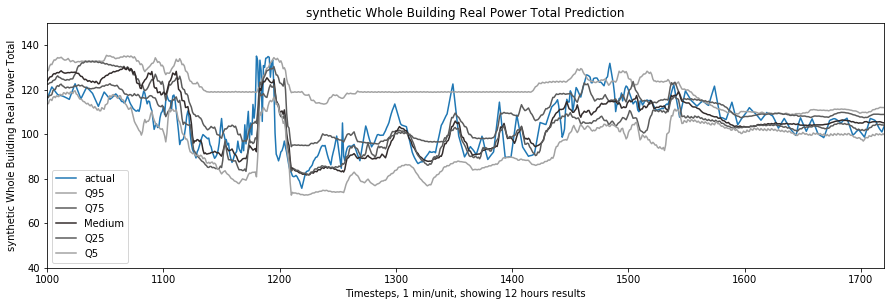

In [9]:
plt.figure(figsize=(15, 4.5))

plt.title(f'{site} Whole Building Real Power Total Prediction')

plt.plot(actual, label = 'actual')
plt.plot(sg_filter(q95.values.flatten(),5,2), label = 'Q95', color = '#a2a2a2')
plt.plot(sg_filter(q75.values.flatten(),5,2), label = 'Q75', color = '#5b5b5b')
plt.plot(sg_filter(q50.values.flatten(),5,2), label = 'Medium', color = '#322b2b')
plt.plot(sg_filter(q25.values.flatten(),5,2), label = 'Q25', color = '#5b5b5b')
plt.plot(sg_filter(q05.values.flatten(),5,2), label = 'Q5', color = '#a2a2a2')


plt.legend()

plt.ylim(40,150)
n=0
plt.xlim(1000, 1720)

plt.ylabel(f'{site} Whole Building Real Power Total')
plt.xlabel('Timesteps, 1 min/unit, showing 12 hours results')

plt.show()

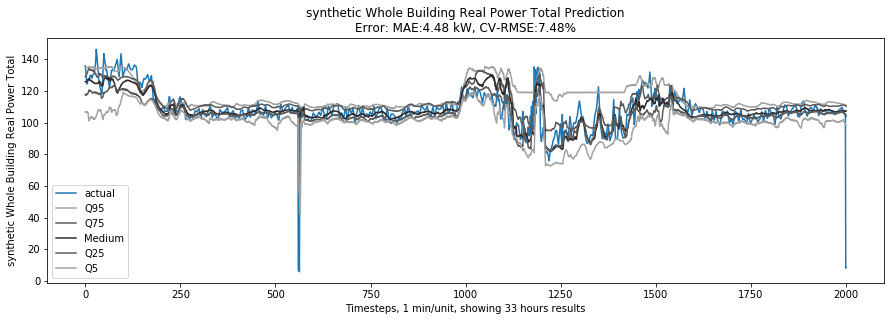

In [10]:
plt.figure(figsize=(15, 4.5))

# calculating error
y_actual = actual
y_predicted = q50.values.flatten()
MSE = mean_squared_error(y_actual, y_predicted)
RMSE = MSE**0.5
CV_RMSE = RMSE/y_actual.mean().values[0]
mae = mean_absolute_error(y_actual, y_predicted)

plt.title(f'{site} Whole Building Real Power Total Prediction\nError: MAE:{mae:.2f} kW, CV-RMSE:{CV_RMSE*100:.2f}%')

plt.plot(actual, label = 'actual')
plt.plot(sg_filter(q95.values.flatten(),5,2), label = 'Q95', color = '#a2a2a2')
plt.plot(sg_filter(q75.values.flatten(),5,2), label = 'Q75', color = '#5b5b5b')
plt.plot(sg_filter(q50.values.flatten(),5,2), label = 'Medium', color = '#322b2b')
plt.plot(sg_filter(q25.values.flatten(),5,2), label = 'Q25', color = '#5b5b5b')
plt.plot(sg_filter(q05.values.flatten(),5,2), label = 'Q5', color = '#a2a2a2')


plt.legend()

# plt.ylim(20,40)
# n=0
# plt.xlim(1000, 1720)

plt.ylabel(f'{site} Whole Building Real Power Total')
plt.xlabel('Timesteps, 1 min/unit, showing 33 hours results')

plt.show()

backup code

In [11]:
# def pinball_np(output, target, alpha):
# #     output.requires_grad = True
# #     target.requires_grad = True
    
# #     output = output.cpu().detach().numpy()
# #     target = target.cpu().detach().numpy()
    
#     tau = 0.5
#     resid = target - output
    
#     log_term = torch.zeros_like(resid)
    
#     log_term[resid < 0] = torch.log(1 + torch.exp(resid[resid < 0] / alpha)) - (resid[resid < 0] / alpha)
#     log_term[resid >= 0] = torch.log(1 + torch.exp(-resid[resid >= 0] / alpha))
#     loss = resid * tau + alpha * log_term
    
# #     loss = torch.from_numpy(loss)
# #     loss = [t.detach().numpy() for t in loss]

# #     loss = (output-target).abs()
    
#     return loss


# def pinball_np(output, target, alpha):
    
#     tau = 0.5
#     resid = target - output
    
#     log_term = torch.zeros_like(resid)
    
#     log_term[resid < 0] = torch.log(1 + torch.exp(resid[resid < 0] / alpha)) - (resid[resid < 0] / alpha)
#     log_term[resid >= 0] = torch.log(1 + torch.exp(-resid[resid >= 0] / alpha))
#     loss = resid * tau + alpha * log_term
    
# #     loss = torch.from_numpy(loss)
# #     loss = [t.detach().numpy() for t in loss]

# #     loss = (output-target).abs()
    
#     return loss



# # test pinball_np
# a = np.array([1.2,2.2,3.2])
# b = np.array([1.1,2.1,3.1])

# a = torch.from_numpy(a)
# b = torch.from_numpy(b)

# quantile_loss(a, b, qs = 0.05)